In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0023.hk',"2017-09-28","2021-09-24")
# data.drop("Adj Close",axis=1,inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-28,33.950001,34.299999,33.700001,34.000000,30.075775,1063217
2017-09-29,33.950001,34.299999,33.599998,33.750000,29.854628,879586
2017-10-03,33.900002,34.500000,33.599998,34.450001,30.473835,758049
2017-10-04,35.000000,35.000000,34.500000,34.650002,30.650753,652209
2017-10-06,34.450001,34.900002,34.099998,34.849998,30.827669,672361


In [3]:
data.shift(1).head(90)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-28,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-29,33.950001,34.299999,33.700001,34.000000,30.075775,1063217.0
2017-10-03,33.950001,34.299999,33.599998,33.750000,29.854628,879586.0
2017-10-04,33.900002,34.500000,33.599998,34.450001,30.473835,758049.0
2017-10-06,35.000000,35.000000,34.500000,34.650002,30.650753,652209.0
...,...,...,...,...,...,...
2018-02-01,34.000000,34.099998,33.549999,33.849998,29.943081,1829659.0
2018-02-02,33.500000,33.700001,33.150002,33.299999,29.456566,2557711.0
2018-02-05,33.049999,33.450001,33.000000,33.049999,29.235418,1118660.0


In [4]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
# data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
data["% Change"]=data["Close"].shift(1).pct_change()
data['3day MA'] = data['Close'].shift(1).rolling(window = 3).mean()
data['10day MA'] = data['Close'].shift(1).rolling(window = 10).mean()
data['30day MA'] = data['Close'].shift(1).rolling(window = 30).mean()
data['Std_dev']= data['Close'].shift(1).rolling(5).std()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 9)
# data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'H-L', 'O-C',
       '% Change', '3day MA', '10day MA', '30day MA', 'Std_dev'],
      dtype='object')

In [5]:
data_options = pd.read_csv("Put_Call_Ratio.csv",skiprows=1)
data_options.columns

Index(['Date (D/M/Y)', ' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [6]:
data_options['Date (D/M/Y)']=pd.to_datetime(data_options['Date (D/M/Y)'], format="%d/%m/%Y")
data_options.set_index('Date (D/M/Y)',inplace=True)
data_options.sort_index(ascending=True,inplace=True)
data_options.columns

Index([' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [7]:
# data=pd.merge(data,data_options[" Put/Call Ratio"], left_index=True,right_index=True)
data=data
# data.drop(["Volume","Adj Close"], axis=1,inplace=True)

In [8]:
data.dropna(inplace=True)
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
H-L          0
O-C          0
% Change     0
3day MA      0
10day MA     0
30day MA     0
Std_dev      0
dtype: int64

In [9]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,3day MA,10day MA,30day MA,Std_dev
Date,,,,,,,,,,,,,
2017-11-13,33.750000,33.750000,32.849998,33.099998,29.279652,2318631,0.900002,-0.650002,-0.008850,33.816667,33.975,34.415000,0.201247
2017-11-14,32.750000,33.400002,32.750000,33.349998,29.500792,1173402,0.650002,0.599998,-0.014881,33.533333,33.835,34.385000,0.338380
2017-11-15,33.400002,33.500000,33.150002,33.200001,29.368109,585022,0.349998,-0.200001,0.007553,33.349998,33.750,34.371666,0.361595
2017-11-16,33.900002,33.900002,33.049999,33.150002,29.323883,833886,0.850002,-0.750000,-0.004498,33.216666,33.630,34.330000,0.323265
2017-11-17,33.400002,33.400002,32.549999,32.650002,28.881588,2741860,0.850002,-0.750000,-0.001506,33.233334,33.530,34.280000,0.201866


In [10]:
data_price=data["Close"]
train=data.shift(1).dropna().values
sc = MinMaxScaler(feature_range=(0,1))
train=sc.fit_transform(train)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(lb-1,len(data)-lb-1):
        X.append(data[i-(lb-1):i])
        Y.append(data_price[(i)])
    return np.array(X),np.array(Y)

lb=7
X,y = processData(train,data_price,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)].reshape(-1,1),y[int(y.shape[0]*0.90):].reshape(-1,1)
# print(type(X_train))
print(X[0])
print(y[0])
print(data.shape)

[[0.92725714 0.92650235 0.91633635 0.90120263 0.89572765 0.02880577
  0.330883   0.36801996 0.36940403 0.94640233 0.98339103 1.
  0.10837042]
 [0.88446724 0.91137055 0.91193307 0.91194146 0.90706136 0.01457789
  0.23897121 0.6852788  0.34882762 0.93392065 0.97693197 0.99861049
  0.19165249]
 [0.91228074 0.91569387 0.92954652 0.90549826 0.90026119 0.00726809
  0.12867594 0.48223334 0.42536287 0.92584425 0.97301039 0.99799292
  0.2057514 ]
 [0.93367569 0.9329875  0.92514308 0.90335052 0.89799456 0.01035987
  0.31250092 0.34263964 0.38425119 0.91997057 0.96747405 0.99606305
  0.18247339]
 [0.91228074 0.91137055 0.90312634 0.88187286 0.87532636 0.0340638
  0.31250092 0.34263964 0.39445762 0.92070483 0.96286044 0.9937472
  0.10874602]
 [0.88018831 0.8897536  0.89431962 0.88187286 0.87532636 0.01713175
  0.20220706 0.53299495 0.34813847 0.91042587 0.95686275 0.99035062
  0.14596659]]
33.0
(953, 13)


In [11]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(844, 6, 13) (844, 1) (94, 6, 13) (94, 1)


In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
# model.add(Dense(32))
model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer='Adam'
)

In [13]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 100)            45600     
_________________________________________________________________
dropout (Dropout)            (None, 6, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 126,101
Trainable params: 126,101
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Fit model with history to check for overfitting
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/300
27/27 [==============================] - 11s 29ms/step - loss: 736.8659 - val_loss: 6.5769
Epoch 2/300
27/27 [==============================] - 0s 6ms/step - loss: 240.0700 - val_loss: 5.5896
Epoch 3/300
27/27 [==============================] - 0s 6ms/step - loss: 170.8044 - val_loss: 16.1997
Epoch 4/300
27/27 [==============================] - 0s 6ms/step - loss: 129.3996 - val_loss: 27.9641
Epoch 5/300
27/27 [==============================] - 0s 6ms/step - loss: 107.5533 - val_loss: 38.8482
Epoch 6/300
27/27 [==============================] - 0s 6ms/step - loss: 95.8857 - val_loss: 47.7929
Epoch 7/300
27/27 [==============================] - 0s 6ms/step - loss: 83.7540 - val_loss: 54.5066
Epoch 8/300
27/27 [==============================] - 0s 6ms/step - loss: 77.1681 - val_loss: 59.3243
Epoch 9/300
27/27 [==============================] - 0s 6ms/step - loss: 72.1131 - val_loss: 62.7424
Epoch 10/300
27/27 [==============================] - 0s 6ms/step - loss: 70.8886 - va

In [15]:
y_pred = model.predict(X_test)

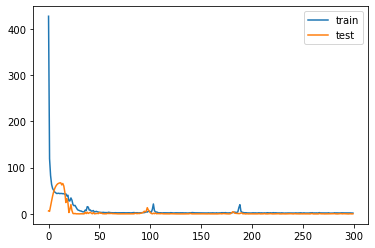

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

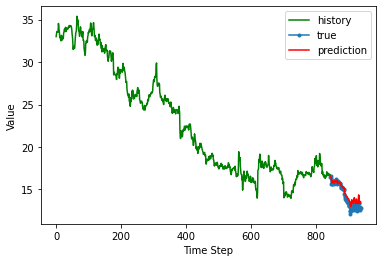

In [17]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [18]:
# plot_x=data[int(X.shape[0]*0.90):]
# plot_x["Prediction"]=y_test

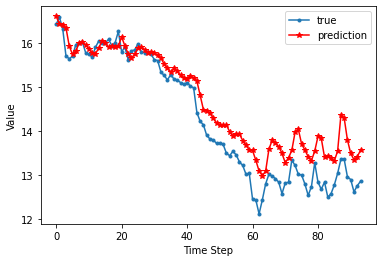

In [19]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [20]:
mean_absolute_percentage_error(y_test,y_pred)*100

3.2134350852162243

In [21]:
mean_squared_error(y_test,y_pred)

0.28295188887723466

In [22]:
y_pred_lstm_final = np.zeros((len(y_pred)-1,))
y_test_t_final = np.zeros((len(y_test)-1,))
for i in range(len(y_pred)-1):
    if y_pred[i+1] >= y_pred[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test)-1):
    if y_test[i+1] >= y_test[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0.]
[1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1.]
Predicted direction accuracy (Up/down):
0.6236559139784946
